In [1]:
import numpy as np
import h5py

Data = h5py.File('Slidingwindow3segments.mat','r')

Bed1 = Data['bed1']
Pod1 = Data['pod1']

Bed2 = Data['bed2']
Pod2 = Data['pod2']

Bed3 = Data['bed3']
Pod3 = Data['pod3']
print(Bed2.shape, Pod2.shape)

(15, 1) (15, 1)


In [2]:
from __future__ import print_function
import time

from scipy.integrate import simps
from scipy.signal import welch
import numpy as np
from scipy import signal
np.random.seed(1234)
from functools import reduce
import math as m

import scipy.io
import theano
import theano.tensor as T
theano.config.optimizer="None"

from scipy.interpolate import griddata
from sklearn.preprocessing import scale


def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [3]:
def generate_band_power(X):
    sf = 1000
#     bandpower_output = []
    output = np.zeros((X.shape[1],3))    #######change to #bands
    for j in range(output.shape[0]):
        output[j,0] = bandpower(X[:,j], sf, [8,13])
        output[j,1] = bandpower(X[:,j], sf, [14,30])
        output[j,2] = bandpower(X[:,j], sf, [30,50])
#         output[j,1] = bandpower(X[:,j], sf, [4,7])
#         output[j,2] = bandpower(X[:,j], sf, [8,13])
#         output[j,3] = bandpower(X[:,j], sf, [11,16])
#         output[j,4] = bandpower(X[:,j], sf, [13,30])

    return output

In [21]:
def figuremakesperatefreq(X1, X2):
    import seaborn as sns
    import scipy.stats
    import matplotlib.pyplot as plt
    # sns.axes_style('white')
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    plt.figure(figsize=(20,20))
    j= []
    for i in range(X1.shape[3]):
        j.append(i)
    np.array(j).shape
    
    ciFactor = scipy.stats.t.ppf(0.975,subjects-1)

    ll = 2
    cha = ['FP1', 'Fp2', 'AF3', 'AF4', 'AF7', 'AF8']  
    frq = ['alpha','beta','gamma']
    for i in range(6):
        plt.subplot(6,3,i*3+1)
        plt.tight_layout(pad=2.0)
        plt.plot(j,np.mean(X1,axis=0)[i,0,:],linewidth= ll )  # Bed Ch 0 and f Alpha
        STD_T = (np.std(X1,axis=0)[i,0,:]/np.sqrt(subjects))*ciFactor
        plt.fill_between(j, np.mean(X1,axis=0)[i,0,:]- STD_T, np.mean(X1,axis=0)[i,0,:] + STD_T,color='blue', alpha=0.2)
        plt.legend(['Bed','Pod'], fontsize=12, bbox_to_anchor=(1, 1),borderaxespad=0)
        plt.ylabel('PSD', fontsize=15)
    #     plt.xlabel('time(s)', fontsize=15)
        plt.title(cha[i]+frq[0], fontsize=20)

        plt.plot(j,np.mean(X2,axis=0)[i,0,:],linewidth= ll)  # Pod Ch 0 and f Alpha
        STD_T = (np.std(X2,axis=0)[i,0,:]/np.sqrt(subjects))*ciFactor
        plt.fill_between(j, np.mean(X2,axis=0)[i,0,:]- STD_T, np.mean(X2,axis=0)[i,0,:] + STD_T,color='orange', alpha=0.2)
        plt.legend(['Bed','Pod'], fontsize=12, bbox_to_anchor=(1, 1),borderaxespad=0)
        plt.ylabel('PSD', fontsize=20)
    #     plt.xlabel('time(s)', fontsize=20)

        plt.subplot(6,3,i*3+2)
        plt.plot(j,np.mean(X1,axis=0)[i,1,:],linewidth= ll)  # Bed Ch 0 and f Alpha
        STD_T = (np.std(X1,axis=0)[i,1,:]/np.sqrt(subjects))*ciFactor
        plt.fill_between(j, np.mean(X1,axis=0)[i,1,:]- STD_T, np.mean(X1,axis=0)[i,1,:] + STD_T,color='blue', alpha=0.2)
        plt.legend(['Bed','Pod'], fontsize=12, bbox_to_anchor=(1, 1),borderaxespad=0)
        plt.ylabel('PSD', fontsize=15)
    #     plt.xlabel('time(s)', fontsize=15)
        plt.title(cha[i]+frq[1], fontsize=20)

        plt.plot(j,np.mean(X2,axis=0)[i,1,:],linewidth= ll)  # Pod Ch 0 and f Alpha
        STD_T = (np.std(X2,axis=0)[i,1,:]/np.sqrt(subjects))*ciFactor
        plt.fill_between(j, np.mean(X2,axis=0)[i,1,:]- STD_T, np.mean(X2,axis=0)[i,1,:] + STD_T,color='orange', alpha=0.2)
        plt.legend(['Bed','Pod'], fontsize=12, bbox_to_anchor=(1, 1),borderaxespad=0)
        plt.ylabel('PSD', fontsize=20)
    #     plt.xlabel('time(s)', fontsize=20)
    
    
        plt.subplot(6,3,i*3+3)
        plt.plot(j,np.mean(X1,axis=0)[i,2,:],linewidth= ll)  # Bed Ch 0 and f Alpha
        STD_T = (np.std(X1,axis=0)[i,2,:]/np.sqrt(subjects))*ciFactor
        plt.fill_between(j, np.mean(X1,axis=0)[i,2,:]- STD_T, np.mean(X1,axis=0)[i,2,:] + STD_T,color='blue', alpha=0.2)
        plt.legend(['Bed','Pod'], fontsize=12, bbox_to_anchor=(1, 1),borderaxespad=0)
        plt.ylabel('PSD', fontsize=15)
    #     plt.xlabel('time(s)', fontsize=15)
    
        plt.title(cha[i]+frq[2], fontsize=20)

        plt.plot(j,np.mean(X2,axis=0)[i,2,:],linewidth= ll)  # Pod Ch 0 and f Alpha
        STD_T = (np.std(X2,axis=0)[i,2,:]/np.sqrt(subjects))*ciFactor
        plt.fill_between(j, np.mean(X2,axis=0)[i,2,:]- STD_T, np.mean(X2,axis=0)[i,2,:] + STD_T,color='orange', alpha=0.2)
        plt.legend(['Bed','Pod'], fontsize=12, bbox_to_anchor=(1, 1),borderaxespad=0)
        plt.ylabel('PSD', fontsize=20)
    #     plt.xlabel('time(s)', fontsize=20)

    

In [12]:
Data[Bed1[1][0]].shape[0]

350001

In [17]:
w = 60000
l = 10000
channels = 6
bands = 3
subjects = 15
min_length = Data[Bed1[1][0]].shape[0]
no_of_windows = (m.ceil(min_length)-w)//l
resultsB = np.zeros((15, channels ,bands, no_of_windows))
resultsP = np.zeros((15, channels ,bands, no_of_windows))
for i in range(15):
    for k in range(0, no_of_windows):
        resultsB[i,:,:,k] = generate_band_power(np.array(Data[Bed1[i][0]])[k*l:k*l+w,:])
        resultsP[i,:,:,k] = generate_band_power(np.array(Data[Pod1[i][0]])[k*l:k*l+w,:])

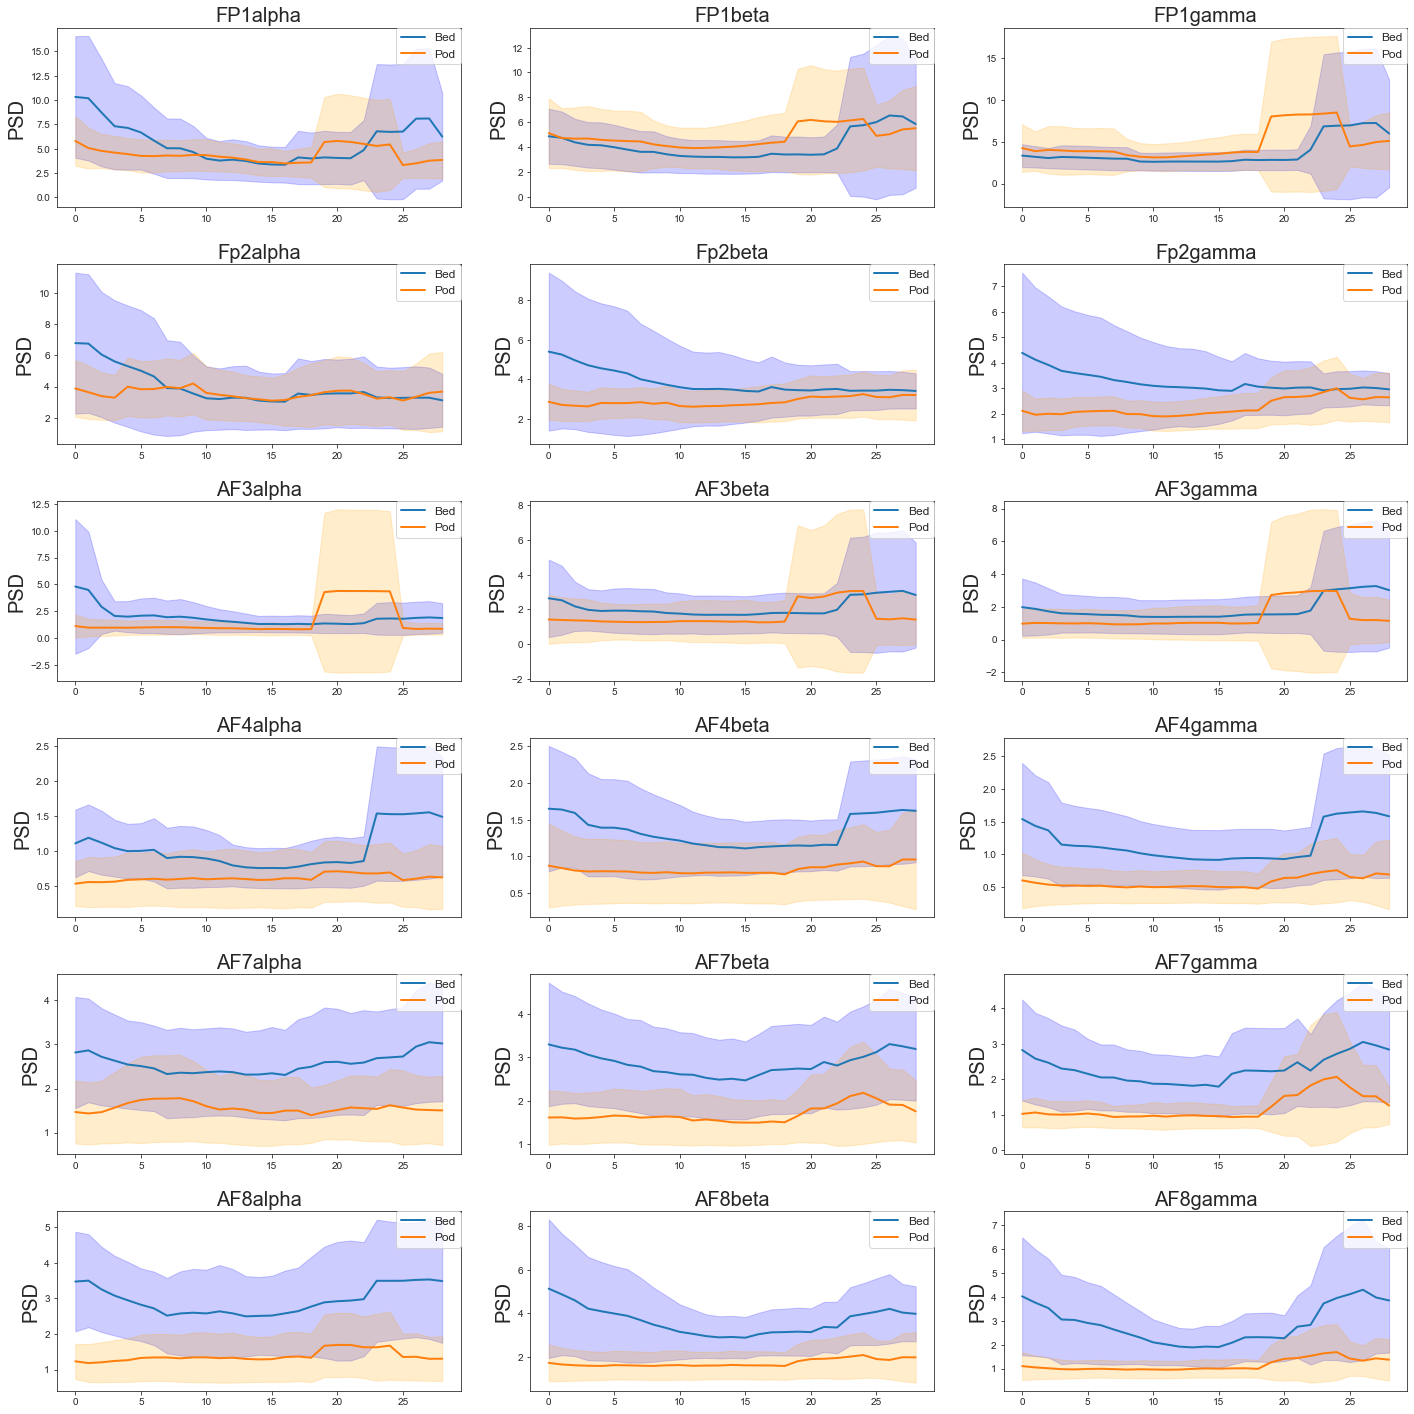

In [22]:
figuremakesperatefreq(resultsB[1:,:,:,:], resultsP[1:,:,:,:])

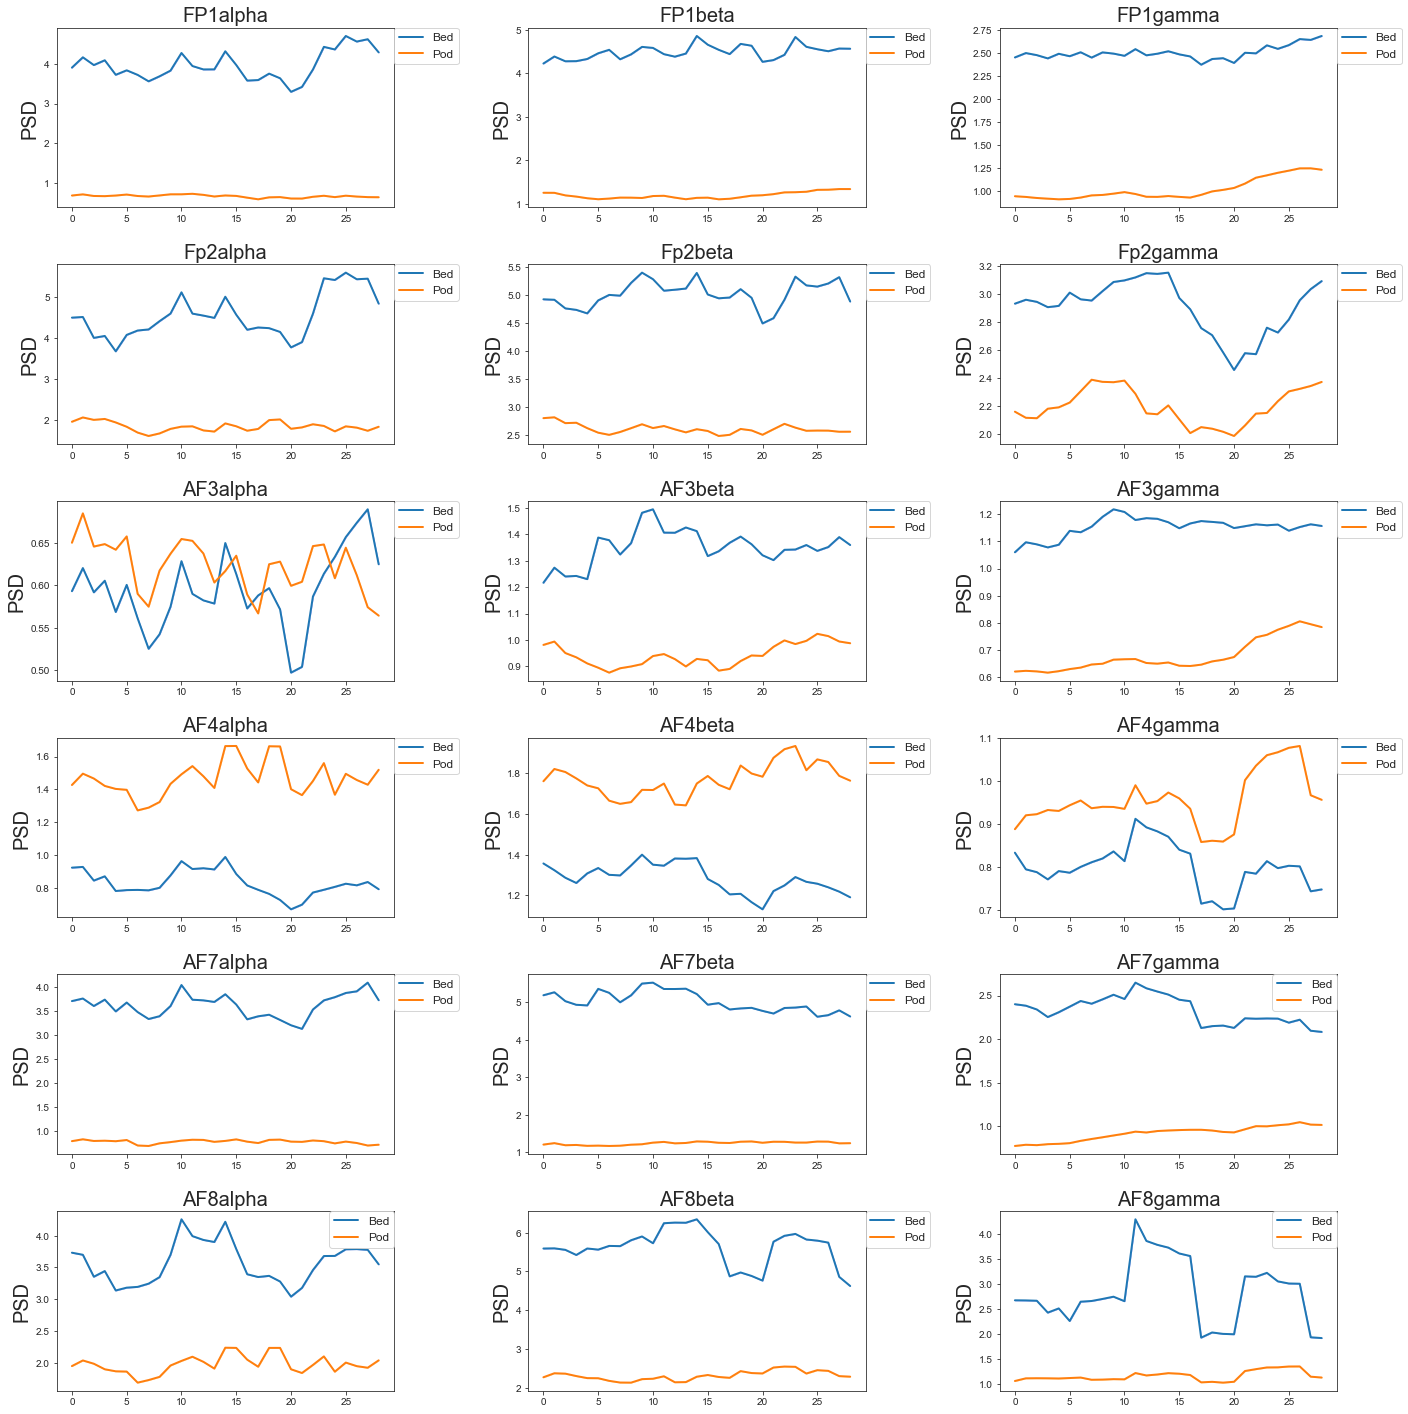

In [34]:
figuremakesperatefreq(resultsB[10:11,:,:,:], resultsP[10:11,:,:,:]) #((15, channels ,bands, no_of_windows))

In [31]:
w = 60000
l = 10000
channels = 6
bands = 3
subjects = 15
min_length = Data[Bed2[1][0]].shape[0]
no_of_windows = (m.ceil(min_length)-w)//l
resultsB = np.zeros((15, channels ,bands, no_of_windows))
resultsP = np.zeros((15, channels ,bands, no_of_windows))
for i in range(15):
    for k in range(0, no_of_windows):
        resultsB[i,:,:,k] = generate_band_power(np.array(Data[Bed2[i][0]])[k*l:k*l+w,:])
        resultsP[i,:,:,k] = generate_band_power(np.array(Data[Pod2[i][0]])[k*l:k*l+w,:])

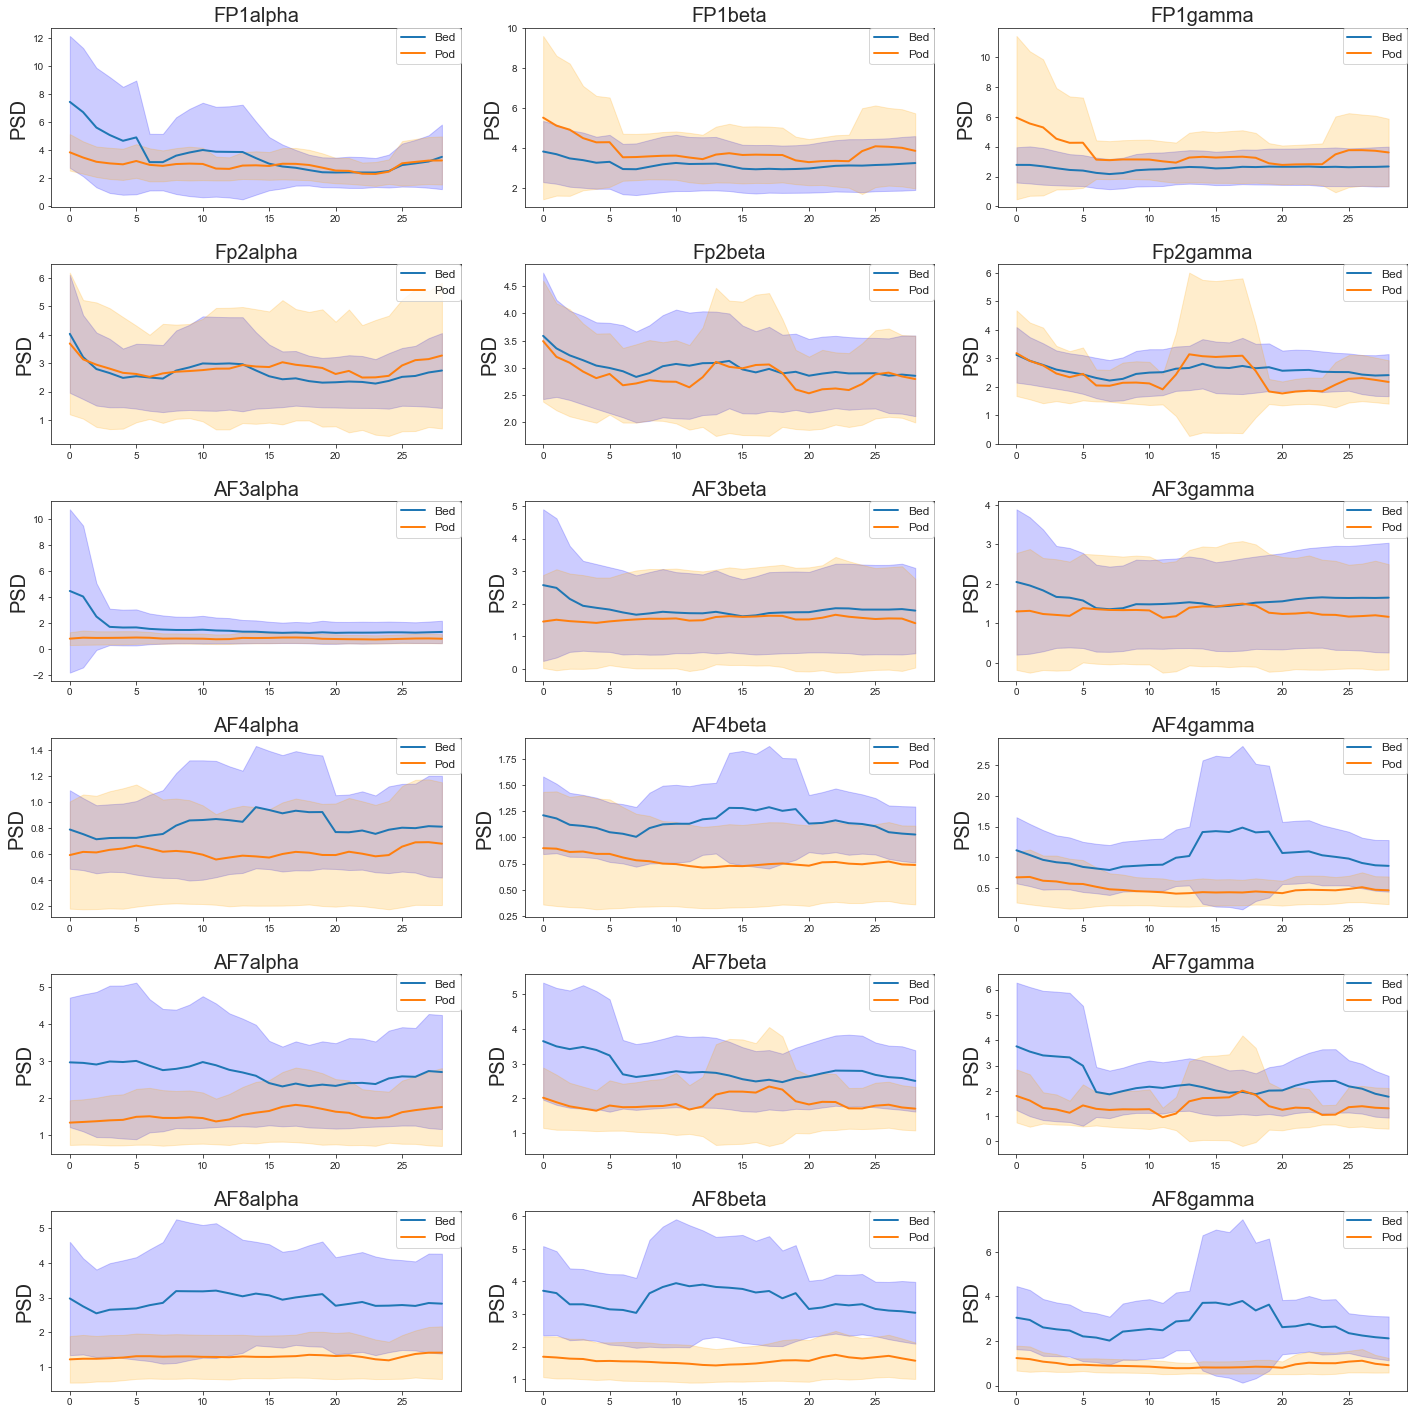

In [32]:
figuremakesperatefreq(resultsB[1:,:,:,:], resultsP[1:,:,:,:])

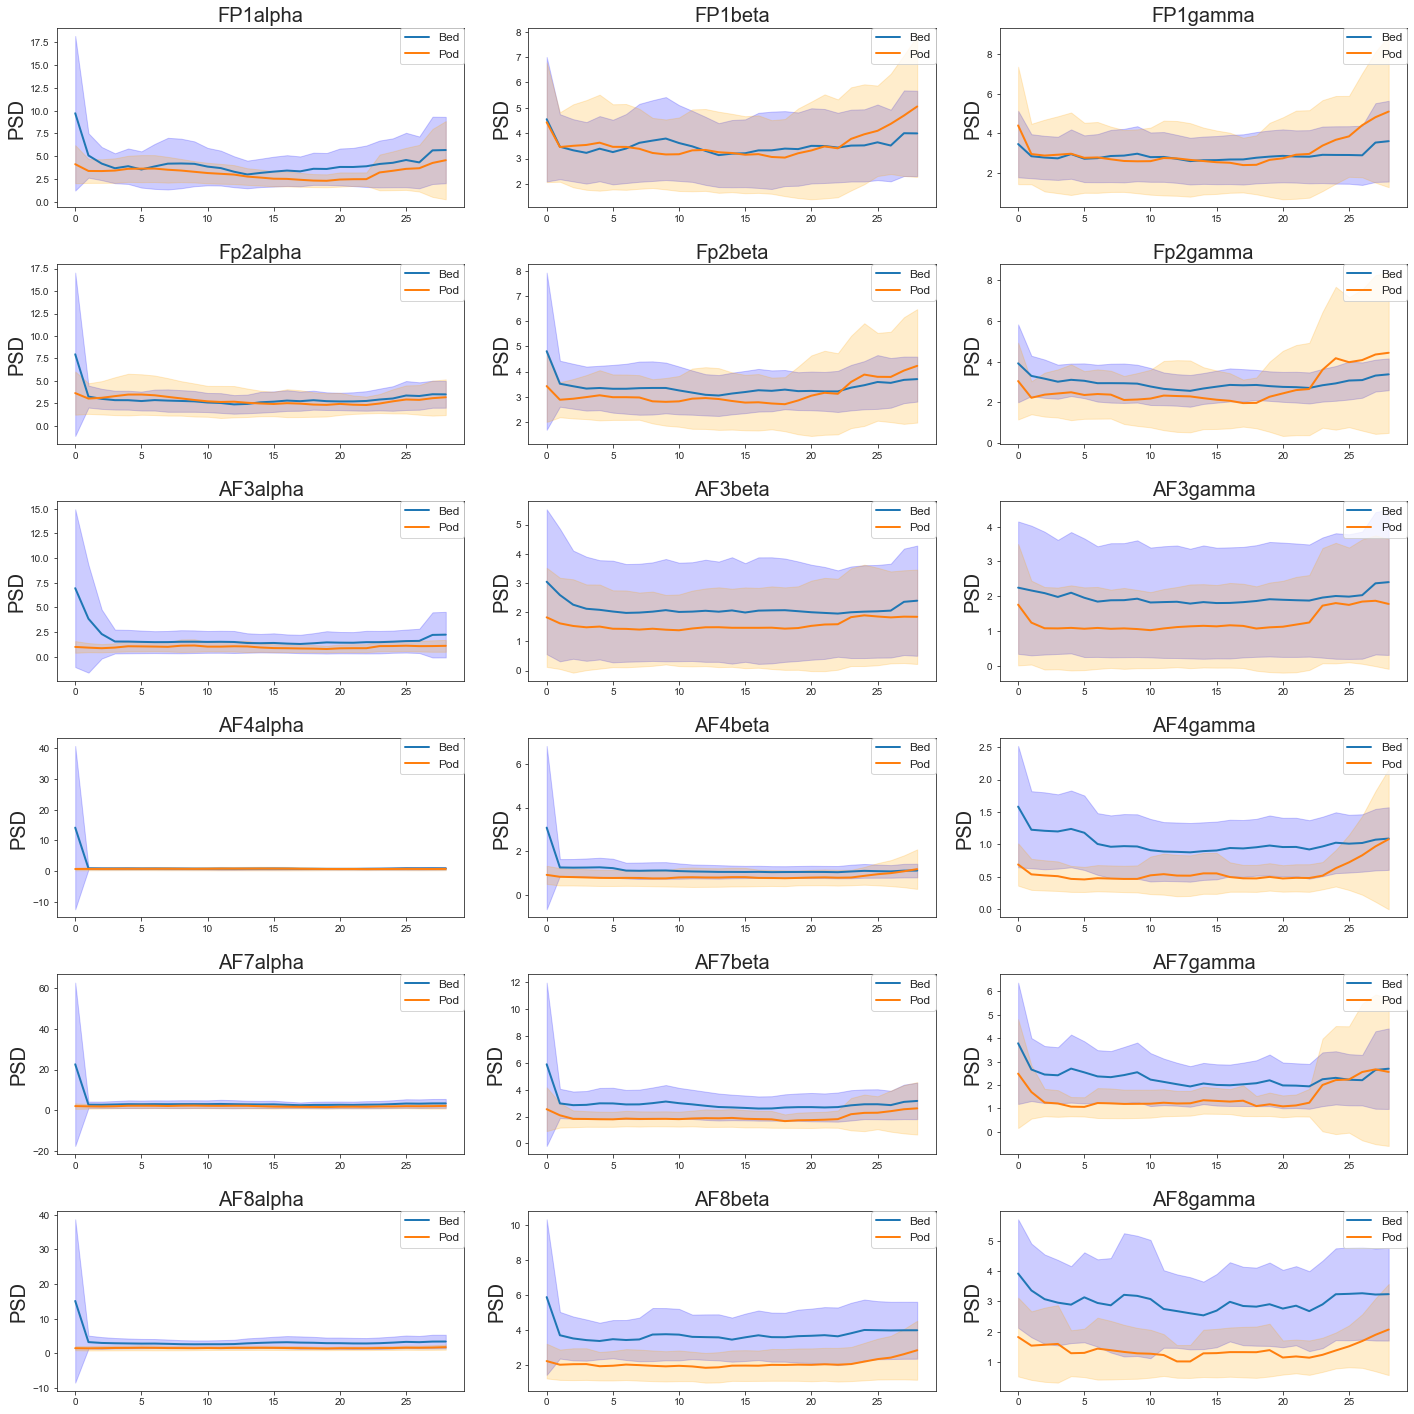

In [33]:
w = 60000
l = 10000
channels = 6
bands = 3
subjects = 15
min_length = Data[Bed3[1][0]].shape[0]
no_of_windows = (m.ceil(min_length)-w)//l
resultsB = np.zeros((15, channels ,bands, no_of_windows))
resultsP = np.zeros((15, channels ,bands, no_of_windows))
for i in range(15):
    for k in range(0, no_of_windows):
        resultsB[i,:,:,k] = generate_band_power(np.array(Data[Bed3[i][0]])[k*l:k*l+w,:])
        resultsP[i,:,:,k] = generate_band_power(np.array(Data[Pod3[i][0]])[k*l:k*l+w,:])
figuremakesperatefreq(resultsB[1:,:,:,:], resultsP[1:,:,:,:])

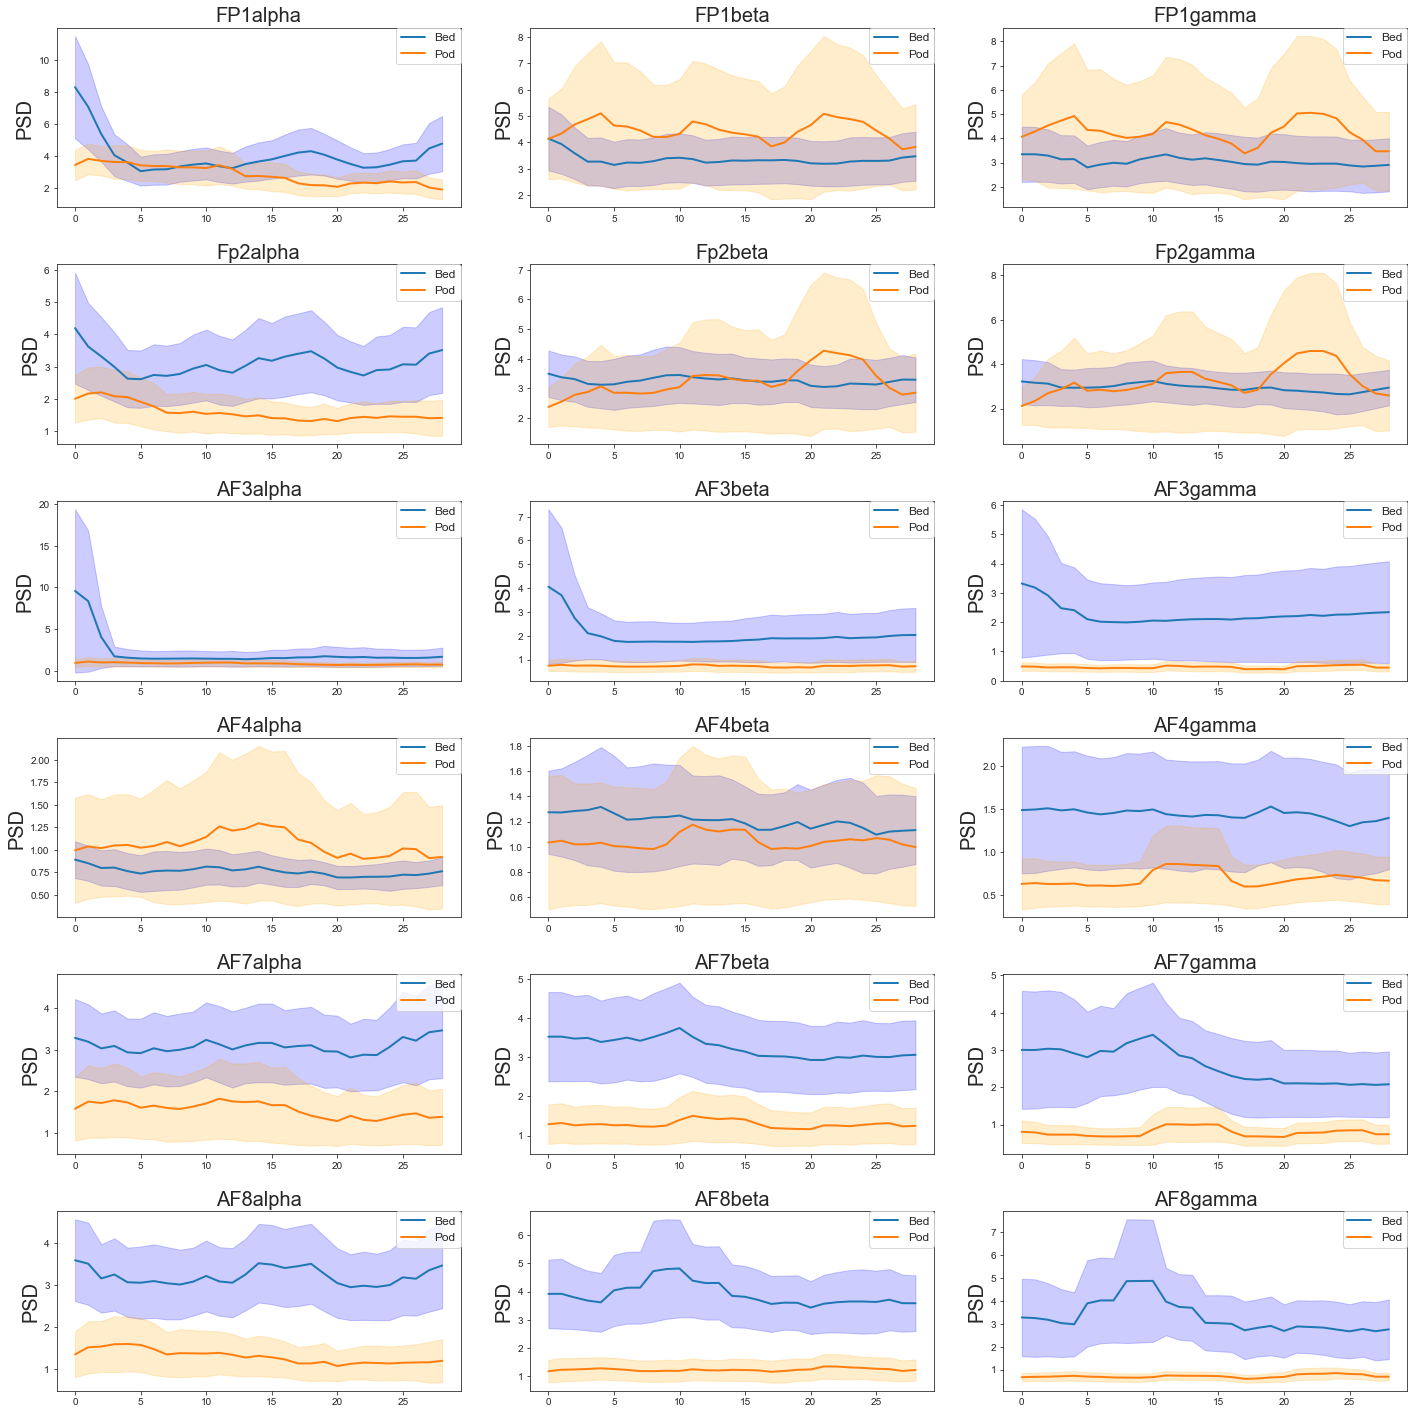

In [38]:
figuremakesperatefreq(resultsB[10:,:,:,:], resultsP[10:,:,:,:])